In [2]:
# pip install -q -U git+https://github.com/lvwerra/trl.git
# !pip install bitsandbytes
# !pip install -q -U git+https://github.com/huggingface/transformers.git
# !pip install -q -U git+https://github.com/huggingface/peft.git
# !pip install -q -U git+https://github.com/huggingface/accelerate.git

ALL OF THE DEPENDENCIES ARE DOWNLOADED STRAIGHT FROM GIT , AS THEY ARE COSNSTANTLY EVOLVING . 

In [3]:
# IMPORT THE DATASET : MODEL NEEDS TO LOOK AT A LOT OF INSTRUCTIONS TO LEARN INSTRUCTION TUNING
from datasets import load_dataset
dolly_15k_dataset = load_dataset("databricks/databricks-dolly-15k")

c:\Users\sansk\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\sansk\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\sansk\.cache\huggingface\hub\datasets--databricks--databricks-dolly-15k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Pyt

In [4]:
dolly_15k_dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 15011
    })
})

In [5]:
import matplotlib.pyplot as plt
from datasets import load_dataset

def plot_sequence_lengths(dataset_obj):
  # initialize a list to store the sequence lenghts
  sequence_lengths = []

  # list of indices that are too long 
  too_long = []
  # loop over the dataset and get the lengths of text sequences
  for idx , example in enumerate(dataset_obj["train"]):
    sequence_lengths.append(len(example["instruction"])+len(example["context"]))
    if sequence_lengths[idx]>2200:
      too_long.append(idx)

  # PLOT THE HISTOGRAM
  plt.hist(sequence_lengths , bins =30)
  plt.xlabel("Sequence length")
  plt.ylabel("Count")
  plt.title("Distribution of Text sequence lengths")
  plt.show()

  return too_long

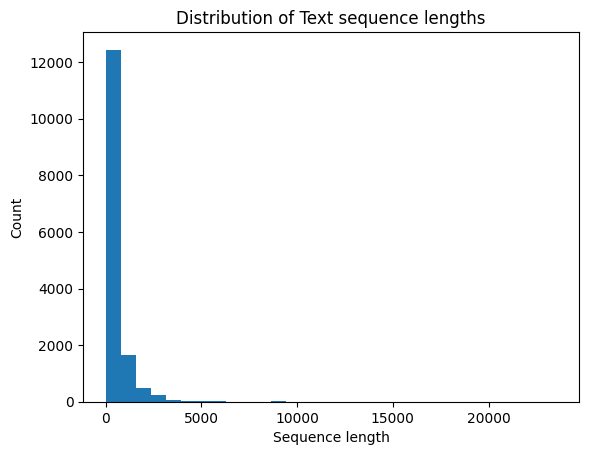

In [6]:
indexes_to_drop = plot_sequence_lengths(dolly_15k_dataset)

In [7]:
# DROP THE INDEXES WHICH CONTAIN VERY LONG SEQUENCE LENGTHS 
len(indexes_to_drop)

513

In [8]:
dolly_15k_reduced = dolly_15k_dataset["train"].select(i for i in range (len(dolly_15k_dataset["train"])) 
                    if i not in set(indexes_to_drop))

Parameter 'indices'=<generator object <genexpr> at 0x0000027FD2F9DEE0> of the transform datasets.arrow_dataset.Dataset.select couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [9]:
dolly_15k_reduced

Dataset({
    features: ['instruction', 'context', 'response', 'category'],
    num_rows: 14498
})

In [10]:
dolly_15k_prepared = dolly_15k_reduced.train_test_split(test_size=0.097, shuffle=False, seed=42)

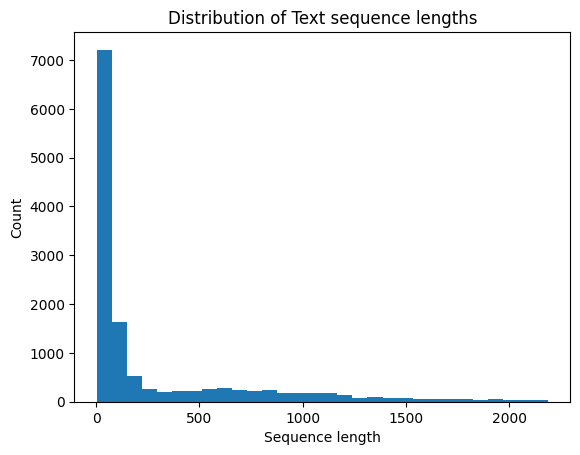

In [11]:
indexes_to_drop= plot_sequence_lengths(dolly_15k_prepared)

In [12]:
dolly_15k_prepared

DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 13091
    })
    test: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 1407
    })
})

Before training , set up a few helper functions, to ensure our dataset is parsed in correct format , and SAVE PEFT ADAPTERS .

In [13]:
# CONVERT THE INSTRUCTIONS FROM 3 SEPERATE COLUMNS - INSTRUCTION , CONTEXT , RESPONSE 
# AND MAKE IT INTO A UNIFIED COLUMN , THAT FOLLOWS OUR DESIRED PROMPTS TEMPLATE 
# THERE ARE TWO OPTIONS : CONTEXT OPTION AND WITHOUT CONTEXT OPTION
# THE LIBRARY WE ARE USING FOR SUPERVISED FINETUNING EXPECTS IT TO BE IN THIS FORMAT 


def formatting(example):
  if example.get("input","") != "":
    input_prompt = (f"Below is an instruction that describes a task, paired with context"
    "Write a response that appropriately completes the request.\n\n"
    "### Instruction:\n"
    f"{example['instruction']}\n\n"
    f"### Input:\n"
    f"{example['context']}\n\n"
    f"### Response: \n"
    f"{example['response']}")
  # if no context is present , following is the input prompt 
  else:
    input_prompt = (f"Below is an instruction that describes a task."
    "Write a response that appropriately completes the request.\n\n"
    "### Instruction:\n"
    f"{example['instruction']}\n\n"
    f"### Response: \n"
    f"{example['response']}")

  return {"text":input_prompt}

In [14]:
# map the formatting func over our dataset
formatted_dataset = dolly_15k_prepared.map(formatting)

Map: 100%|██████████| 1407/1407 [00:00<00:00, 5387.06 examples/s]


In [15]:
formatted_dataset
# this dataset contains a new column called instructions which contains full text instructions 

DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category', 'text'],
        num_rows: 13091
    })
    test: Dataset({
        features: ['instruction', 'context', 'response', 'category', 'text'],
        num_rows: 1407
    })
})

In [16]:
formatted_dataset["train"][1]["text"]

'Below is an instruction that describes a task.Write a response that appropriately completes the request.\n\n### Instruction:\nWhich is a species of fish? Tope or Rope\n\n### Response: \nTope'

We have the dolly 15k dataset pared down to a more reasonable length We can set up a model We will be using QLORA for this portion , this ensure a low memory footprint during fine-tuning